In [1]:
# Import library
from google.colab import files
from zipfile import ZipFile
import cv2
import os

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Upload Segmentation zip file
uploaded = files.upload()

Saving SegmentationNew (4).zip to SegmentationNew (4).zip


In [3]:
# Specify zip file name
file_name = "SegmentationNew (4).zip"

# Extract dataset
with ZipFile(file_name, 'r') as zip:
    zip.printdir() # Print all files in the zip file
    print('Extracting all files...')
    zip.extractall("LeafSegmentationDisease") # Extracts all files into a new folder
    print('Dataset extracted successfully!')

File Name                                             Modified             Size
Training/                                      2025-12-09 03:18:14            0
Validation/                                    2025-12-09 03:18:16            0
Training/Apple___Apple_scab/                   2025-12-09 03:18:08            0
Training/Apple___Black_rot/                    2025-12-09 03:18:08            0
Training/Apple___Cedar_apple_rust/             2025-12-09 03:18:08            0
Training/Apple___healthy/                      2025-12-09 03:18:08            0
Training/Blueberry___healthy/                  2025-12-09 03:18:08            0
Training/Cherry_(including_sour)___Powdery_mildew/ 2025-12-09 03:18:10            0
Training/Cherry_(including_sour)___healthy/    2025-12-09 03:18:10            0
Training/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/ 2025-12-09 03:18:10            0
Training/Corn_(maize)___Common_rust_/          2025-12-09 03:18:10            0
Training/Corn_(maize)_

In [4]:
# Define dataset directories
train_path = "/content/LeafSegmentationDisease/Training"
test_path = "/content/LeafSegmentationDisease/Validation"

# Data Cleaning
def clean_dataset(dataset_path, dataset_name="Dataset"):
    total_images = 0
    corrupted_images = 0

    print(f"\nChecking dataset: {dataset_name}")

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)

            # Try reading the image
            img = cv2.imread(file_path)
            if img is None:
                os.remove(file_path)
                corrupted_images += 1
                continue

            total_images += 1

    print("\n--- Summary ---")
    print(f"Total valid images in {dataset_name}: {total_images}")
    print(f"Total corrupted images removed: {corrupted_images}")

# Run cleaning on both datasets
clean_dataset(train_path, "training")
clean_dataset(test_path, "validation")



Checking dataset: training

--- Summary ---
Total valid images in training: 1323
Total corrupted images removed: 0

Checking dataset: validation

--- Summary ---
Total valid images in validation: 570
Total corrupted images removed: 0


In [5]:
# Setting constants
BATCH_SIZE = 32
Image_size = 224
target_size = (Image_size, Image_size)
input_shape = (Image_size, Image_size, 3)
grid_shape = (1, Image_size, Image_size, 3)
dataset_root = "/content/LeafSegmentationDisease"

train_dir = os.path.join(dataset_root, "Training")
test_dir = os.path.join(dataset_root, "Validation")

In [6]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(Image_size, Image_size),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 1323 images belonging to 38 classes.


In [7]:
# Get the list of categories in training data
cats = list(train_data.class_indices.keys())

In [8]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(Image_size, Image_size),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 570 images belonging to 38 classes.


In [9]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [13]:
# Num epochs
epochs = 15

# Train model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs,
    callbacks=[early_stopping_cb]
)


Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6902 - loss: 1.1170 - val_accuracy: 0.7772 - val_loss: 0.8891
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7297 - loss: 0.9084 - val_accuracy: 0.7877 - val_loss: 0.8007
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.7780 - loss: 0.8416 - val_accuracy: 0.7912 - val_loss: 0.7514
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7611 - loss: 0.7815 - val_accuracy: 0.8193 - val_loss: 0.6988
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8118 - loss: 0.6906 - val_accuracy: 0.8193 - val_loss: 0.6376
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8057 - loss: 0.6923 - val_accuracy: 0.8263 - val_loss: 0.6247
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7942 - loss: 0.6646 - val_accuracy: 0.8333 - val_loss: 0.5850
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8466 - loss: 0.5440 - val_accuracy: 0.8368 - val_los

In [14]:
model.evaluate(test_data)

18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8472 - loss: 0.5144


[0.48523709177970886, 0.8491228222846985]

In [15]:
# Unfreeze last few layers of MobileNetV2
base_model = model.get_layer('mobilenetv2_1.00_224')
base_model.trainable = True

for layer in base_model.layers[:130]:
    layer.trainable = False

In [30]:
from tensorflow.keras.optimizers import Adam

# Compile with lower learning rate
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=history.epoch[-1] + 10,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping_cb]
)

Epoch 15/24
42/42 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.6465 - loss: 1.2886 - val_accuracy: 0.8474 - val_loss: 0.4858
Epoch 16/24
42/42 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.6981 - loss: 0.9909 - val_accuracy: 0.8491 - val_loss: 0.4938
Epoch 17/24
42/42 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7658 - loss: 0.7547 - val_accuracy: 0.8421 - val_loss: 0.5017
Epoch 18/24
42/42 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.7778 - loss: 0.7565 - val_accuracy: 0.8368 - val_loss: 0.5149
Epoch 19/24
42/42 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.8205 - loss: 0.6467 - val_accuracy: 0.8351 - val_loss: 0.5155
Epoch 20/24
42/42 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.8375 - loss: 0.5704 - val_accuracy: 0.8351 - val_loss: 0.5194


In [17]:
model.save("LeafDiseaseDetection_MobilenetV2.h5")

In [18]:
from google.colab import files
files.download("/content/LeafDiseaseDetection_MobilenetV2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

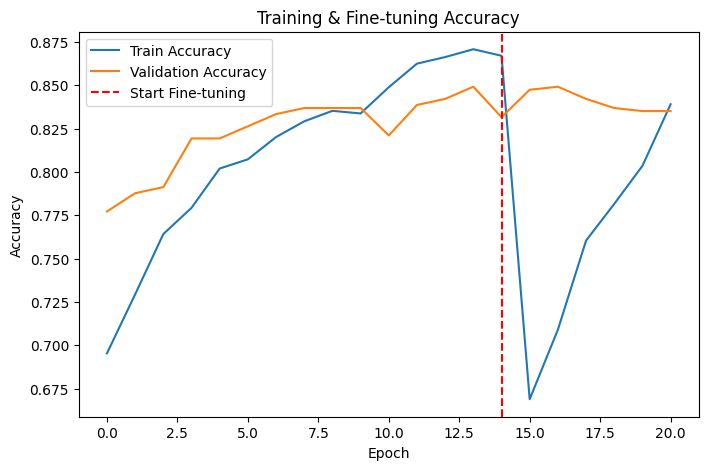

In [31]:
import matplotlib.pyplot as plt
phase1_epochs = len(history.history['accuracy'])

acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

plt.figure(figsize=(8,5))
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.axvline(
    x=phase1_epochs-1,
    color='red',
    linestyle='--',
    label='Start Fine-tuning'
)

plt.title("Training & Fine-tuning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


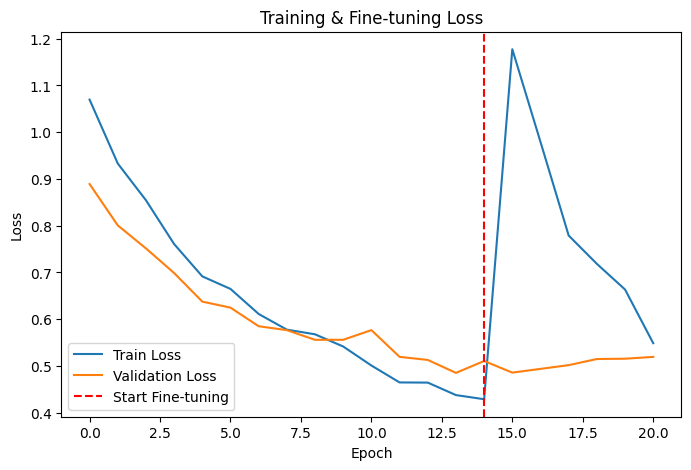

In [32]:
# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

# Optional: mark start of fine-tuning
plt.axvline(
    x=phase1_epochs-1,
    color='red',
    linestyle='--',
    label='Start Fine-tuning'
)

plt.title("Training & Fine-tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step
Final Test Accuracy: 84.74%



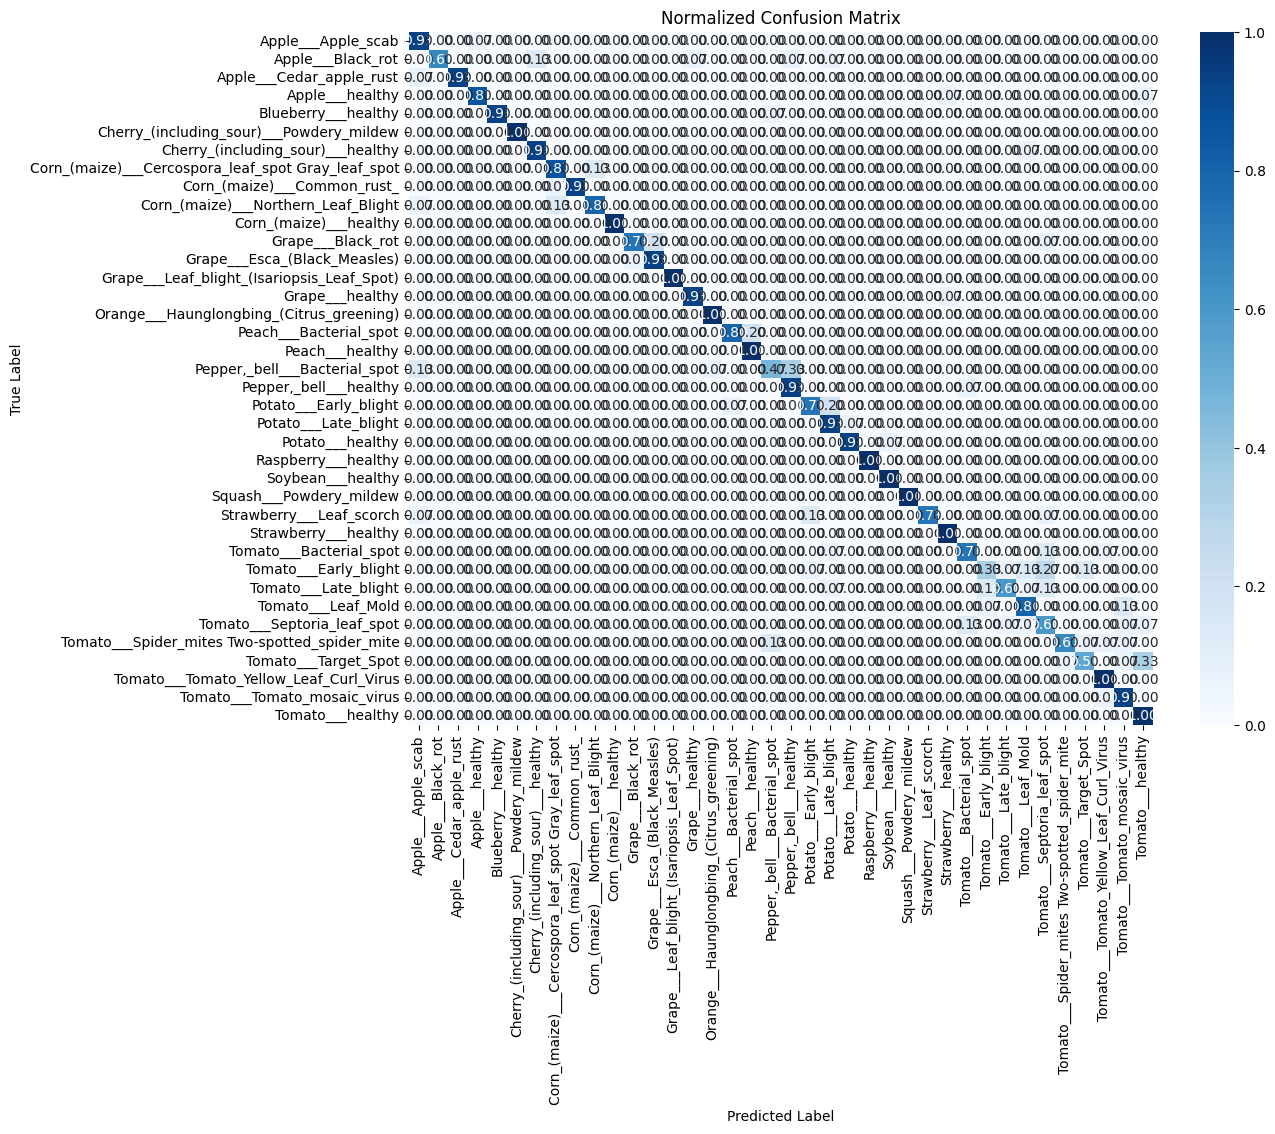

CLASSIFICATION REPORT:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.74      0.93      0.82        15
                                 Apple___Black_rot       1.00      0.67      0.80        15
                          Apple___Cedar_apple_rust       1.00      0.93      0.97        15
                                   Apple___healthy       0.93      0.87      0.90        15
                               Blueberry___healthy       1.00      0.93      0.97        15
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00        15
                 Cherry_(including_sour)___healthy       0.88      0.93      0.90        15
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.81      0.87      0.84        15
                       Corn_(maize)___Common_rust_       1.00      0.93      0.97        15
               Corn_(maize)___Northern_Leaf_Blight     

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make sure test_data is NOT shuffled
test_data.shuffle = False
test_data.reset()

# Predict on the test set
y_pred_probs = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_data.classes

# Final Test Accuracy
final_accuracy = np.mean(y_pred_classes == y_true)
print(f"Final Test Accuracy: {final_accuracy*100:.2f}%\n")

# Class names from test_data (automatic)
class_names = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(12,9))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("CLASSIFICATION REPORT:\n")
print(report)
